# Atmospheric Simulation 

In this notebook you may find a really dummy atmospheric simulation performed with `pycal`. We use the LSPE/STRIP focal plane and we simulate the correlation level between the detectors. 

As you know, the atmosphere load is not uniform also for a CES. The telescope line of sight scan the atmospheric structure and the load fluctuations are recorded in the TOD. So, if you look the single detector TOD, you can see very large fluctuations due to the water vapor structures that are just seen by this specific detector.

The temporal correlation is not the only correlated noise intruduced by the atmospheric load. The same vater wapor structures that was seen previously by that specific decetor, are seen also by others detectors in the focal planes. In this way we can find also a spatial correlation between the detector.

### A recap:
- The single detector TOD present time correlation due to the atmospheric structures (Time Correlation)
- These atmospheric structures are seen also by the other detectors of the focal plane, so they introduce a really strong level of correlation between them. (Spatial Correlation)

The most commons strategies to reduce the atmospheric effects are focused on mitigation of the spatial correlations between the detectors. This process can be done in different ways, using a rotating HWP (or more in general a polarization modulator) that works really good if your signal is polarized, and using the boresight axis of the telescope in the scanning strategy. We can see that only the correct use of the boresight axis can largely mitigated the atmospheric noise.


In [1]:
import pycal
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pylab as plt
from pycal.mpi import MPI, Comm, get_world
from pycal.todmap import *
from pycal import Data

In [2]:
communicator=MPI.COMM_WORLD
rank=communicator.Get_rank

In [3]:
azmin=(14/180)*np.pi
azmax=(36/180)*np.pi
elmin=(60/180)*np.pi
elmax=(80/180)*np.pi
tmin=0.0
tmax=3600
lmin_center=20
lmin_sigma=0
lmax_center=600
lmax_sigma=0
w_center=20
w_sigma=0
wdir_center=np.pi/6
wdir_sigma=0
z0_center=2000
z0_sigma=0
T0_center=280.0
T0_sigma=5.0
zatm=40000.0
zmax=2000.0
xstep=80.0
ystep=80.0
zstep=80.0
nelem_sim_max=200
verbosity=1
comm=communicator
key1=0
key2=81458
counterval1=0
counterval2=0
cachedir="/home/algebrato/Progetti/CMB4G/libcal/cookbook/atm_cache"
rmin=0
rmax=10000

### The environment

In [4]:
#if rank==0:
env=pycal.Environment.get()
print(env)

<cal.Environment
  Source code version = 0.0.0
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 12
  MPI build enabled
  MPI runtime enabled
>


### Scanning Strategy

1200.0


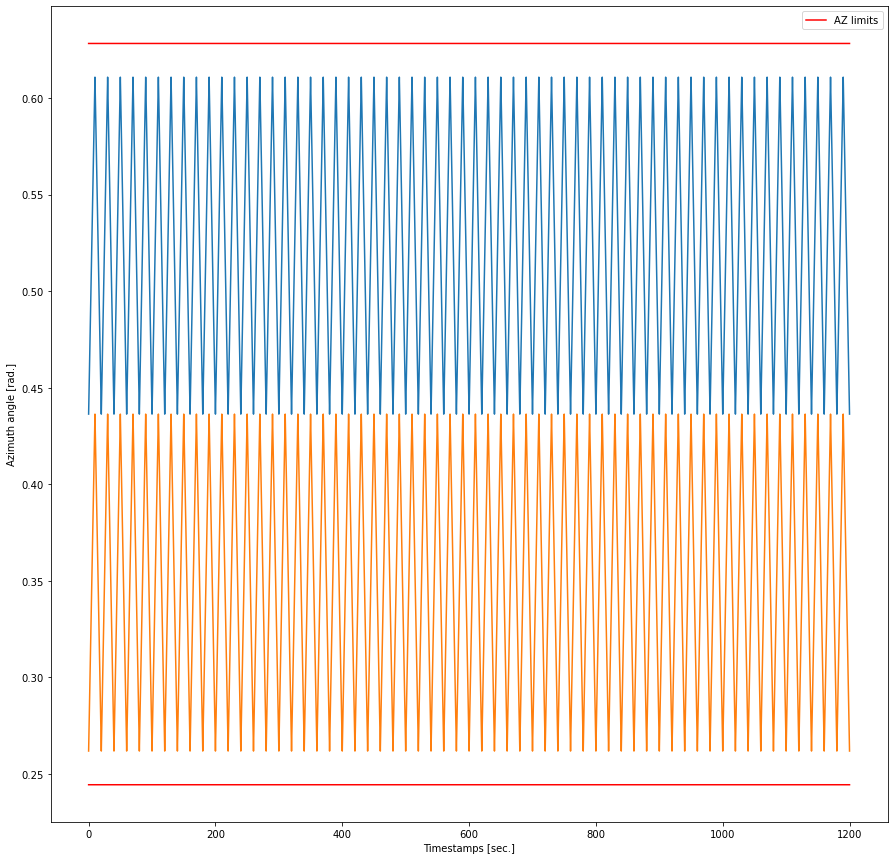

In [5]:
# samples frequency
fs_hz=25
tmax = tmax/3
print(tmax)
# timestamp in seconds (now we simulate 1h of observations)
times=np.linspace(0,tmax,int(tmax)*fs_hz)

# Now we perform a really dummy CES at 72deg of elevation
# and with an AZ span of 10deg
el=np.ones(int(tmax)*fs_hz)*(72/180)*np.pi

azmin_tod=(20/180)*np.pi
azmax_tod=(30/180)*np.pi
az1=np.linspace(azmin_tod,azmax_tod,10*fs_hz)
az=az1
for i in range(0, int((tmax/10)-1)):
    az1=np.flip(az1)
    az=np.append(az, az1)

# initialize the TOD buffers
tod0=np.zeros(int(tmax)*fs_hz)
tod1=np.zeros(int(tmax)*fs_hz)
tod2=np.zeros(int(tmax)*fs_hz)
tod3=np.zeros(int(tmax)*fs_hz)
tod4=np.zeros(int(tmax)*fs_hz)

plt.figure(1, figsize=(15,15))
plt.plot(times, az+((5/180)*np.pi))
plt.plot(times, az-((5/180)*np.pi))
plt.plot(times, np.ones(int(tmax)*fs_hz)*azmin,'r-', label="AZ limits")
plt.plot(times, np.ones(int(tmax)*fs_hz)*azmax,'r-')
plt.xlabel("Timestamps [sec.]")
plt.ylabel("Azimuth angle [rad.]")
plt.legend(loc='best')

# plt.figure(2)
# plt.plot(times, 0.05*np.sin((np.pi/6)*times)+0.45)
# plt.xlim((0,50))

# print((0.1*180/np.pi)/6)

In [6]:
# This is a mockup focalplane of 5 detectors. The central plus four othogonal detector in pairs, respectively.

# obs=dict()
# obs['name']="20200709_00"

# tod=dict()
# tod['det0']=np.zeros(int(tmax)*fs_hz)
# tod['det1']=np.zeros(int(tmax)*fs_hz)
# tod['det2']=np.zeros(int(tmax)*fs_hz)
# tod['det3']=np.zeros(int(tmax)*fs_hz)
# tod['det4']=np.zeros(int(tmax)*fs_hz)

# obs['tod']=tod
# comm = communicator
# data = pycal.Data(comm)

# data.obs.append(obs)

# data.obs[0]['tod']['det0']

In [7]:
# The LSPE/STRIP Focalplane

import yaml
with open(r'/home/algebrato/.julia/dev/Stripeline/instrumentdb/strip_focal_plane.yaml') as file:
    focalplane=yaml.full_load(file)

detecotrs=focalplane['horns'].keys()
tod=dict()

for i in detecotrs:
    directions=focalplane['horns'][i]['orientation']
    l=np.arctan(directions[0]/directions[2])
    u=np.arctan(directions[1]/directions[2])
    tod[i]={'signal':np.zeros(int(tmax)*fs_hz), 'l':l, 'u':u}
    
obs=dict()
obs['name'] = "Strip_1H_Full_Focal_Plane"
obs['tod'] = tod

comm=communicator
data=pycal.Data(comm)

data.obs.append(obs)

In [8]:
detecotrs

dict_keys(['I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'O0', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'G0', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6'])

### Create the atmospheric simulation

The `AtmSimMPI` creates an atmosphere out of the principat weather parameter like <br/>
$L_0$, $l_0$ = The outer and inner correlation length, respectively. They depend on the energy injection and dissipation prosess within the atmosphere.<br/>
$w$, $w_{dir}$ = The wind speed and directions. The wind blows the atmospheric structes rigidly across the telescope line of sight.<br/>
$Z_0$ = The cut-off altitude of the water vapor<br/>
$T_0$ = The ground temeperature. In `pycal` the vetial gradient of temperature is considered linear. The tropopause discontinituy is negligible due to the water-vapor cut-off.


In [9]:
atm=pycal.AtmSimMPI(azmin, 
                    azmax, 
                    elmin, 
                    elmax, 
                    tmin, 
                    tmax, 
                    lmin_center, 
                    lmin_sigma, 
                    lmax_center, 
                    lmax_sigma, 
                    w_center, 
                    w_sigma, 
                    wdir_center, 
                    wdir_sigma, 
                    z0_center, 
                    z0_sigma, 
                    T0_center, 
                    T0_sigma, 
                    zatm, 
                    zmax, 
                    xstep, 
                    ystep, 
                    zstep, 
                    nelem_sim_max, 
                    verbosity, 
                    comm, 
                    key1, 
                    key2, 
                    counterval1, 
                    counterval2, 
                    cachedir, 
                    rmin, 
                    rmax
)

In [10]:
# Start the atmosphere simulation (Evaluation of the correlations and wind evolutions)
err = atm.simulate(True)
communicator.Barrier()

In [11]:
for i in detecotrs:
    l = data.obs[0]['tod'][i]['l']
    u = data.obs[0]['tod'][i]['u']
    atm.observe(times, az+l, el+u, data.obs[0]['tod'][i]['signal'], -1)
    communicator.Barrier()


MPI.Finalize()


In [12]:
det_ob=data.obs[0]['tod']
tod_matrix=dict()

for i in detecotrs:
    tod_matrix[i]=det_ob=data.obs[0]['tod'][i]['signal']

matrix = pd.DataFrame(tod_matrix)

matrix.to_csv(r"TOD_matrix.csv",index = False, header=True)


MTX_CX=matrix.corr()

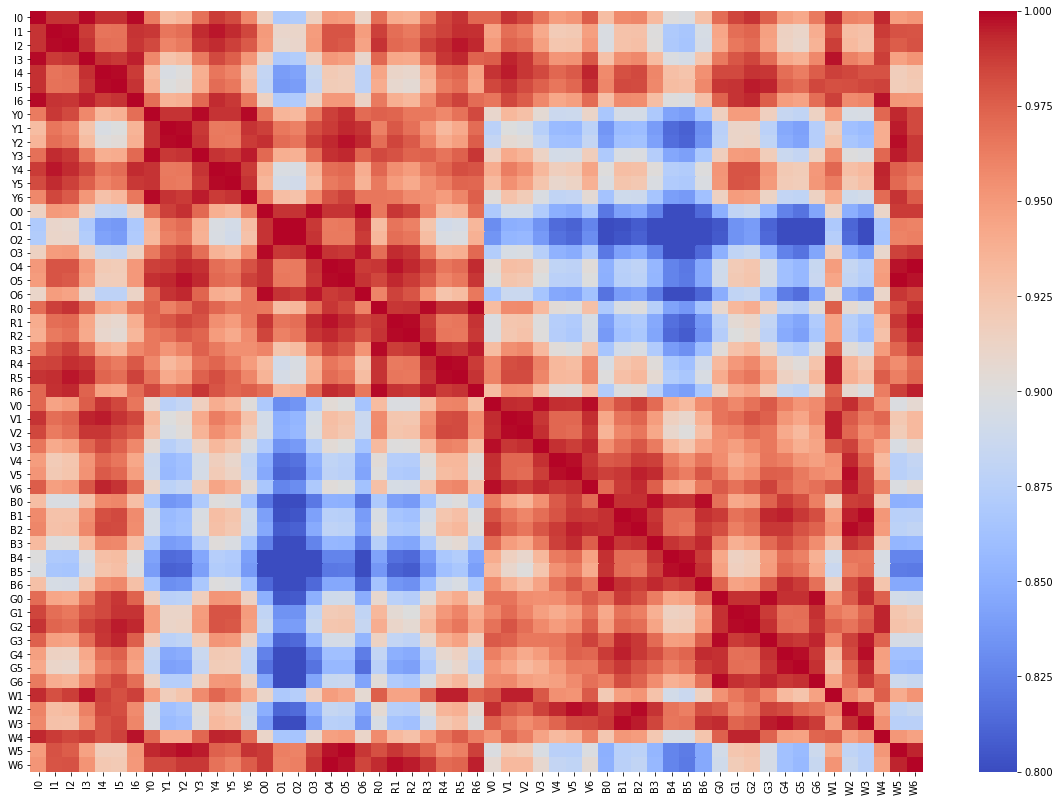

In [13]:
plt.figure(1, figsize=(20,14))
sn.heatmap(MTX_CX, annot=False, cmap='coolwarm', center=0.9, vmin=0.8, vmax=1)


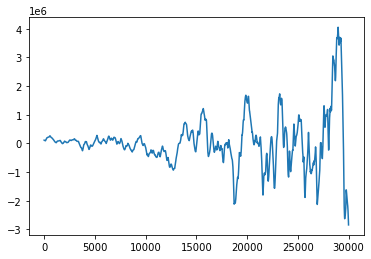

In [15]:
plt.plot(data.obs[0]['tod']['G0']['signal'])

In [15]:
abso_vec=pycal.atm_absorption_coefficient_vec(5000, 280, 101500, 5, 40, 50, 500)
load_vec=pycal.atm_atmospheric_loading_vec(5000, 280, 101500, 5, 40, 50, 500)


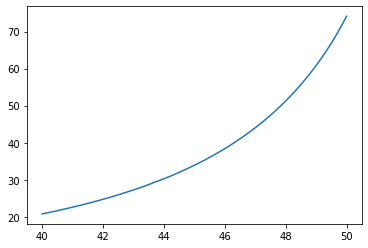

In [16]:
#plt.plot(np.linspace(40, 50, 500), abso_vec)
plt.plot(np.linspace(40, 50, 500), load_vec)

In [17]:
a=pycal.atm_absorption_coefficient(5000, 280, 101500, 2, 150)
b=pycal.atm_atmospheric_loading(5000, 280, 101500, 2, 57)

In [18]:
print(a,b)

0.06043288090984156 277.6659993620258


In [19]:
fmin=1/300
fmax=12.5
freq=np.linspace(fmin,fmax,int(len(tod_k)/2))
tod_k_fft=np.fft.fftshift(np.fft.fft(tod_k))
plt.loglog(freq,np.real(tod_k_fft[int(len(tod_k)/2)::])**2 + np.imag(tod_k_fft[int(len(tod_k)/2)::])**2)

NameError: name 'tod_k' is not defined

In [23]:
1/170

0.0058823529411764705

In [24]:
1/0.012

83.33333333333333

In [25]:
1/25

0.04

In [26]:
1/0.04

25.0

In [27]:
tmax/5

60.0

In [28]:
def get_comm():
    log = pycal.Logger.get()
    env = pycal.Environment.get()
    mpiworld, procs, rank = get_world()

    # This is the 2-level toast communicator.  By default,
    # there is just one group which spans MPI_COMM_WORLD.
    comm = Comm(world=mpiworld)
    return mpiworld, procs, rank, comm

In [ ]:
mpiworld, procs, rank, comm = get_comm()
atmsim=OpSimAtmosphere()

In [58]:
dati=Data(comm)
dati.comm

<cal.Comm
  World MPI communicator = <mpi4py.MPI.Intracomm object at 0x7f6b2b743c90>
  World MPI size = 1
  World MPI rank = 0
  Group MPI communicator = <mpi4py.MPI.Intracomm object at 0x7f6b2b743c90>
  Group MPI size = 1
  Group MPI rank = 0
  Rank MPI communicator = <mpi4py.MPI.Intracomm object at 0x7f6b2b743c70>
>

In [59]:
atmsim.exec(dati)

UnboundLocalError: local variable 'comm' referenced before assignment

In [1]:
from pycal.weather import *
import astropy
import datetime

In [2]:
alto_chor=Weather("weather_QUBIC.fits",1,1)

In [3]:
days=np.linspace(0,200000,10000)
hum=np.array([])

for i in days:
    alto_chor.set_time(int(i))
    hum=np.append(hum, alto_chor.air_temperature)


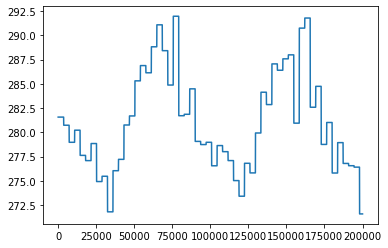

In [6]:
plt.plot(days,hum)

In [52]:
days

array([0.])

In [94]:
datetime.datetime.utcfromtimestamp(51*365*24*60*60)

datetime.datetime(2020, 12, 19, 0, 0)

In [75]:
24*60*60

86400

In [98]:
d=datetime.datetime.now()

In [22]:
from toast.todmap.atm import AtmSim
import numpy as np
import matplotlib.pylab as plt

azmin=(14/180)*np.pi
azmax=(36/180)*np.pi
elmin=(60/180)*np.pi
elmax=(80/180)*np.pi
tmin=0.0
tmax=500
lmin_center=20
lmin_sigma=0
lmax_center=600
lmax_sigma=0
w_center=20
w_sigma=0
wdir_center=np.pi/6
wdir_sigma=0
z0_center=2000
z0_sigma=0
T0_center=280.0
T0_sigma=5.0
zatm=40000.0
zmax=2000.0
xstep=80.0
ystep=80.0
zstep=80.0
nelem_sim_max=200
verbosity=1
comm=None
key1=325
key2=10000+int(tmax)*25
counterval1=34567 
counterval2=600000
cachedir="/home/algebrato/Progetti/CMB4G/libcal/cookbook/atm_cache"
rmin=0
rmax=10000

fs_hz=25
ss=(1/180)*np.pi
times=np.linspace(0,tmax,int(tmax)*fs_hz)
el=np.ones(int(tmax)*fs_hz)*(72/180)*np.pi
# az=np.ones(int(tmax)*fs_hz)*(25/180)*np.pi

azmin_tod=(20/180)*np.pi
azmax_tod=(30/180)*np.pi
az1=np.linspace(azmin_tod,azmax_tod,10*fs_hz)
az=az1
for i in range(0, int((tmax/10)-1)):
    az1=np.flip(az1)
    az=np.append(az, az1)
tod0=np.zeros(int(tmax)*fs_hz)
tod1=np.zeros(int(tmax)*fs_hz)
tod2=np.zeros(int(tmax)*fs_hz)
tod3=np.zeros(int(tmax)*fs_hz)
tod4=np.zeros(int(tmax)*fs_hz)


In [23]:
atmosphere=AtmSim(azmin=azmin, azmax=azmax, elmin=elmin, elmax=elmax, tmin=tmin, tmax=tmax, lmin_center=lmin_center,  lmin_sigma=lmin_sigma, 
        lmax_center=lmax_center, lmax_sigma=lmax_sigma, w_center=w_center, w_sigma=w_sigma, wdir_center=wdir_center, 
        wdir_sigma=wdir_sigma, z0_center=z0_center, z0_sigma=z0_sigma, T0_center=T0_center, T0_sigma=T0_sigma, zatm=zatm, zmax=zmax,
        xstep=xstep, ystep=ystep, zstep=zstep, nelem_sim_max=nelem_sim_max, comm=None, key1=key1, 
        key2=key2, counterval1=counterval1, counterval2=counterval2, cachedir=cachedir, rmin=rmin, rmax=rmax, write_debug=True)

In [24]:
atmosphere.simulate()

0

In [25]:
atmosphere.observe(times, az-((5/180)*np.pi), el, tod0)

0

In [26]:
atmosphere.observe(times, az, el-((5/180)*np.pi), tod1)
atmosphere.observe(times, az, el, tod2)
atmosphere.observe(times, az+((5/180)*np.pi), el, tod3)
atmosphere.observe(times, az-((5/180)*np.pi), el, tod4)

0

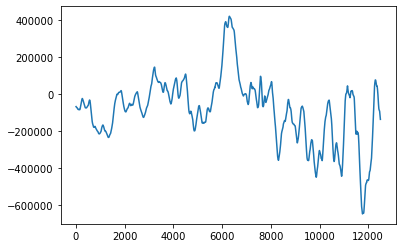

In [27]:
plt.plot(tod0)

55

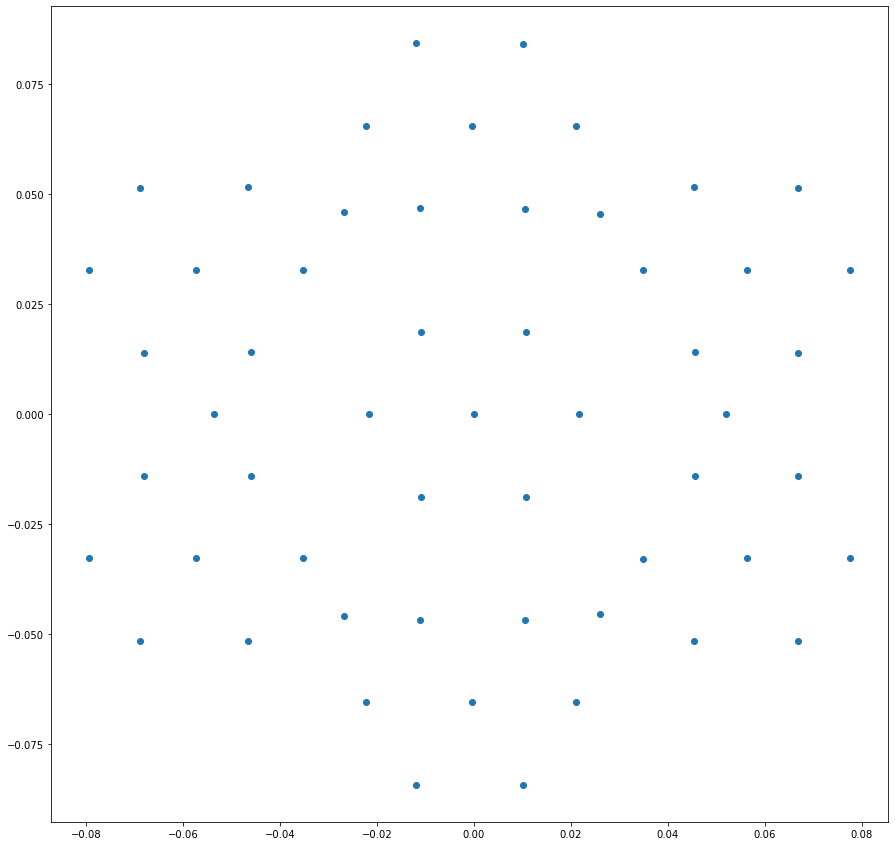

In [16]:
plt.figure(figsize=(15,15))
ll = np.array([])
uu = np.array([])

for i in detecotrs:
    l=data.obs[0]['tod'][i]['l']
    u=data.obs[0]['tod'][i]['u']
    ll=np.append(ll, l)
    uu=np.append(uu, u)
    
plt.plot(ll,uu, 'o')
len(detecotrs)